In [1]:
import torch

from e2cnn import gspaces
from e2cnn import nn

In [2]:
r2_act = gspaces.Rot2dOnR2(N=4)

In [3]:
feat_type_in = nn.FieldType(r2_act, [r2_act.trivial_repr])
feat_type_out = nn.FieldType(r2_act, 3*[r2_act.regular_repr])

In [4]:
conv = nn.R2Conv(feat_type_in, feat_type_out, kernel_size=3)

/home/wagner/Development/deeplearning/singular-points/lib/python3.10/site-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  full_mask[mask] = norms.to(torch.uint8)


In [5]:
x = torch.randn(4, 1, 32, 32)
x = nn.GeometricTensor(x, feat_type_in)

assert isinstance(x.tensor, torch.Tensor)

In [6]:
y = conv(x)

In [7]:
assert y.type == feat_type_out

In [8]:
# for each group element
for g in r2_act.testing_elements:
    # transform the input with the current group element according to the input type
    x_transformed = x.transform(g)
    
    # feed the transformed input in the convolutional layer
    y_from_x_transformed = conv(x_transformed)
    
    # the result should be equivalent to rotating the output produced in the 
    # previous block according to the output type
    y_transformed_from_x = y.transform(g)
    assert torch.allclose(y_from_x_transformed.tensor, y_transformed_from_x.tensor, atol=1e-5), g

In [9]:
relu = nn.ReLU(feat_type_out)
z = relu(y)

# for each group element
for g in r2_act.testing_elements:
    y_transformed = y.transform(g)
    z_from_y_transformed = relu(y_transformed)
    
    z_transformed_from_y = z.transform(g)
    
    assert torch.allclose(z_from_y_transformed.tensor, z_transformed_from_y.tensor, atol=1e-5), g

In [10]:
layer1 = nn.R2Conv(feat_type_in, feat_type_out, kernel_size=3)
layer2 = nn.ReLU(feat_type_in) # the input type of the ReLU should be the output type of the convolution

x = nn.GeometricTensor(torch.randn(3, 1, 7, 7), feat_type_in)

try:
    y = layer2(layer1(x))
except AssertionError as e:
    print(e)

Error! the type of the input does not match the input type of this module


In [11]:
eat_type_in = nn.FieldType(r2_act, [r2_act.trivial_repr])
feat_type_hid = nn.FieldType(r2_act, 8*[r2_act.regular_repr])
feat_type_out = nn.FieldType(r2_act, 2*[r2_act.regular_repr])

model = nn.SequentialModule(
    nn.R2Conv(feat_type_in, feat_type_hid, kernel_size=3),
    nn.InnerBatchNorm(feat_type_hid),
    nn.ReLU(feat_type_hid),
    nn.R2Conv(feat_type_hid, feat_type_hid, kernel_size=3),
    nn.InnerBatchNorm(feat_type_hid),
    nn.ReLU(feat_type_hid),
    nn.R2Conv(feat_type_hid, feat_type_out, kernel_size=3),
).eval()

In [12]:
x = torch.randn(1, 1, 17, 17)
x = nn.GeometricTensor(x, feat_type_in)

y = model(x)

# for each group element
for g in r2_act.testing_elements:
    x_transformed = x.transform(g)
    y_from_x_transformed = model(x_transformed)
    
    y_transformed_from_x = y.transform(g)
    print(y_transformed_from_x.shape)
    assert torch.allclose(y_from_x_transformed.tensor, y_transformed_from_x.tensor, atol=1e-5), g

torch.Size([1, 8, 11, 11])
torch.Size([1, 8, 11, 11])
torch.Size([1, 8, 11, 11])
torch.Size([1, 8, 11, 11])


In [13]:
avgpool = nn.PointwiseAvgPool(feat_type_out, 11)

y = avgpool(model(x))

print(y.shape)

torch.Size([1, 8, 1, 1])


In [14]:
for i in range(4):
    print(f'rotation by {i}*pi/2:', y.transform(i).tensor[0, ...].detach().numpy().squeeze())

rotation by 0*pi/2: [0.4134 0.4572 0.4514 0.4243 0.2002 0.237  0.2423 0.2226]
rotation by 1*pi/2: [0.4243 0.4134 0.4572 0.4514 0.2226 0.2002 0.237  0.2423]
rotation by 2*pi/2: [0.4514 0.4243 0.4134 0.4572 0.2423 0.2226 0.2002 0.237 ]
rotation by 3*pi/2: [0.4572 0.4514 0.4243 0.4134 0.237  0.2423 0.2226 0.2002]


In [15]:
invariant_map = nn.GroupPooling(feat_type_out)

y = invariant_map(avgpool(model(x)))

for i in range(4):
    print(f'rotation by {i}*pi/2:', y.transform(i).tensor[0, ...].detach().numpy().squeeze())

rotation by 0*pi/2: [0.4572 0.2423]
rotation by 1*pi/2: [0.4572 0.2423]
rotation by 2*pi/2: [0.4572 0.2423]
rotation by 3*pi/2: [0.4572 0.2423]


In [16]:
# for each group element
for g in r2_act.testing_elements:
    # rotated the input image
    x_transformed = x.transform(g)
    y_from_x_transformed = invariant_map(avgpool(model(x_transformed)))
    
    y_transformed_from_x = y # no .transform(g) needed since y should be invariant!
    
    # check that the output did not change
    # note that here we are not rotating the original output y as before
    assert torch.allclose(y_from_x_transformed.tensor, y_transformed_from_x.tensor, atol=1e-6), g

## Campo vetorial


/home/wagner/Development/deeplearning/singular-points/lib/python3.10/site-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  full_mask[mask] = norms.to(torch.uint8)


[[0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]] 
 [[4 4 4 4 4]
 [3 3 3 3 3]
 [2 2 2 2 2]
 [1 1 1 1 1]
 [0 0 0 0 0]]


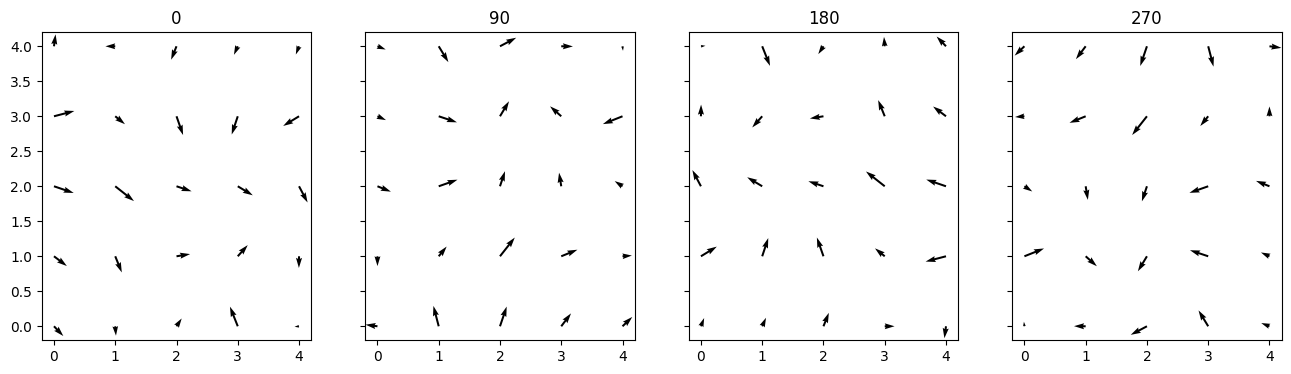

In [17]:
import matplotlib.pyplot as plt
import numpy as np

feat_type_in = nn.FieldType(r2_act, [r2_act.trivial_repr])
feat_type_hid = nn.FieldType(r2_act, 8*[r2_act.regular_repr])

feat_type_out = nn.FieldType(r2_act, [r2_act.irrep(1)])

model = nn.SequentialModule(
    nn.R2Conv(feat_type_in, feat_type_hid, kernel_size=3),
    nn.InnerBatchNorm(feat_type_hid),
    nn.ReLU(feat_type_hid),
    nn.R2Conv(feat_type_hid, feat_type_hid, kernel_size=3),
    nn.InnerBatchNorm(feat_type_hid),
    nn.ReLU(feat_type_hid),
    nn.R2Conv(feat_type_hid, feat_type_out, kernel_size=3),
).eval()


S = 11
x = torch.randn(1, 1, S, S)
x = nn.GeometricTensor(x, feat_type_in)

fig, axs = plt.subplots(1, r2_act.fibergroup.order(), sharex=True, sharey=True, figsize=(16, 4))

X, Y = np.meshgrid(range(S-6), range(S-7, -1, -1))
print(X,'\n',Y)
# for each group element
for i, g in enumerate(r2_act.testing_elements):
    # transform the input
    x_transformed = x.transform(g)
    
    y = model(x_transformed)
    y = y.tensor.detach().numpy().squeeze()

    # plot the output vector field
    axs[i].quiver(X, Y, y[0, ...], y[1, ...], units='xy')
    axs[i].set_title(g*90)
    
plt.show()

In [18]:
norm_relu = nn.NormNonLinearity(feat_type_out, 'n_relu')

y = norm_relu(model(x))

for g in r2_act.testing_elements:
    x_transformed = x.transform(g)
    y_from_x_transformed = norm_relu(model(x_transformed))
    
    y_transformed_from_x = y.transform(g)
    
    assert torch.allclose(y_from_x_transformed.tensor, y_transformed_from_x.tensor, atol=1e-5), g

# Diferentes espaço de recursos

In [19]:
scalar_fields = nn.FieldType(r2_act, 2*[r2_act.trivial_repr])# 1 dim
regular_fields = nn.FieldType(r2_act, 1*[r2_act.regular_repr])# 4 dim
vector_field = nn.FieldType(r2_act, 1*[r2_act.irrep(1)])# 2 dim
feat_type_out = scalar_fields + regular_fields + vector_field

In [20]:
r2_act.irrep(1)

C4|irrep_1:2,1,2.0

In [21]:
relu = nn.ReLU(scalar_fields + regular_fields)
norm_relu = nn.NormNonLinearity(vector_field)

nonlinearity = nn.MultipleModule(
                    feat_type_out,
                    ['relu']*len(scalar_fields+regular_fields) + ['norm']*len(vector_field),
                    [(relu, 'relu'), (norm_relu, 'norm')]
)

In [22]:
feat_type_in = nn.FieldType(r2_act, [r2_act.trivial_repr])
feat_type_hid = nn.FieldType(r2_act, 2*[r2_act.regular_repr])

model = nn.SequentialModule(
    nn.R2Conv(feat_type_in, feat_type_hid, kernel_size=3),
    nn.InnerBatchNorm(feat_type_hid),
    nn.ReLU(feat_type_hid),
    nn.R2Conv(feat_type_hid, feat_type_out, kernel_size=3),
    nonlinearity,
).eval()

x = torch.randn(1, 1, 17, 17)
x = nn.GeometricTensor(x, feat_type_in)

y = model(x)

for g in r2_act.testing_elements:
    x_transformed = x.transform(g)
    y_from_x_transformed = model(x_transformed)
    
    y_transformed_from_x = y.transform(g)
    
    assert torch.allclose(y_from_x_transformed.tensor, y_transformed_from_x.tensor, atol=1e-5), g

In [23]:
y.shape

torch.Size([1, 8, 13, 13])

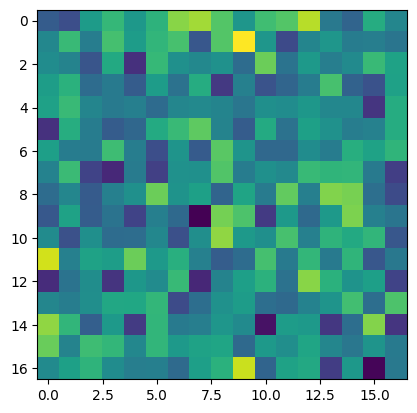

In [24]:
plt.imshow(x.tensor[0][0].detach().numpy())
plt.show()